In [8]:
import zipfile
from zipfile import ZipFile
import os 
import io
import cv2
import random
import matplotlib.pyplot as plt

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [20]:
mri_files=zipfile.ZipFile("D:\data\mri2.Zip")
mri_files.extractall("D:\data")
mri_files.close()         

In [21]:
root_dir = 'D:/data/dataset/'

#### 데이터 준비 및 전처리

##### 이미지 예시 출력

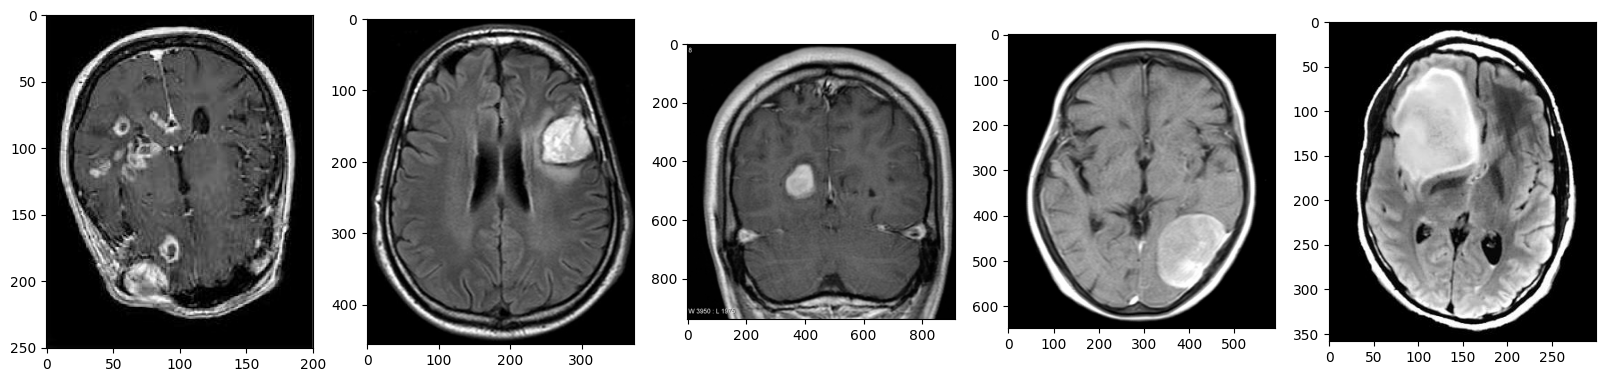

In [23]:
# Train data의 뇌종양 데이터 랜덤하게 5개 확인하기 
mri_train_path = os.path.join(root_dir, 'train', 'yes')

mri_files  = [os.path.join(mri_train_path, x) for x in os.listdir(mri_train_path)]
mri_images = [cv2.imread(x) for x in random.sample(mri_files, 5)]

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(mri_images):
    # plt.subplot(len(mri_images) / columns + 1, columns, i + 1)
    plt.subplot(int(len(mri_images) / columns + 1), columns, i + 1)

    plt.imshow(image)

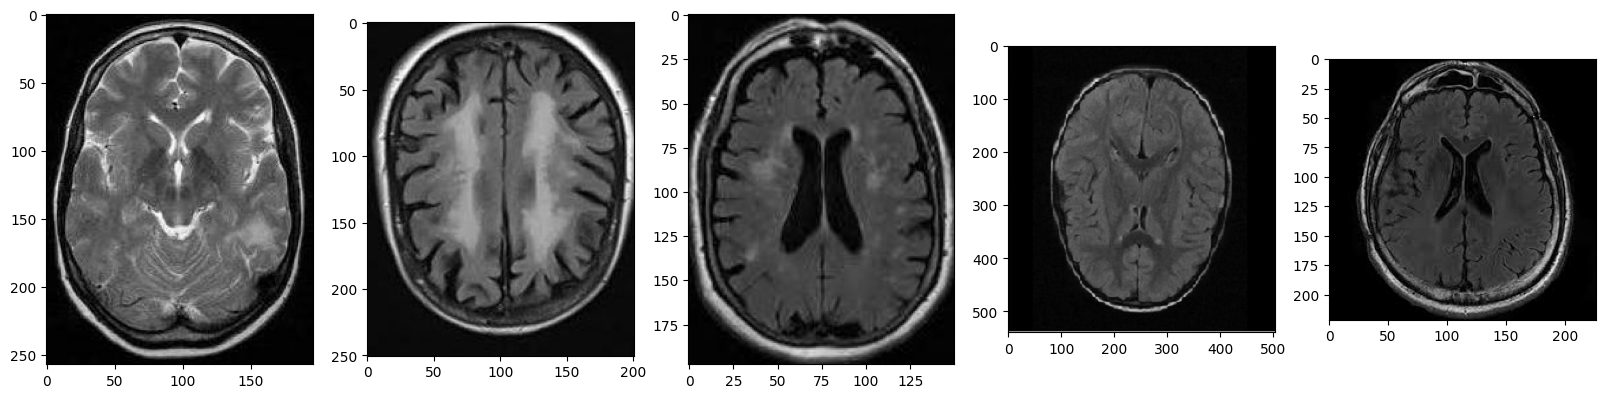

In [24]:
# Train data의 정상 데이터 랜덤하게 5개 확인하기
mri_train_path = os.path.join(root_dir, 'train', 'no')

mri_files  = [os.path.join(mri_train_path, x) for x in os.listdir(mri_train_path)]
mri_images = [cv2.imread(x) for x in random.sample(mri_files, 5)]

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(mri_images):
    plt.subplot(int(len(mri_images) / columns + 1), columns, i + 1)
    plt.imshow(image)

#### 데이터 분포 확인

In [25]:
def print_files_in_dir(root_dir, prefix):
    files = os.listdir(root_dir)
    lab = ['yes', 'no']
    for i, file in enumerate(files):
        path = os.path.join(root_dir, file)
        file_list = os.listdir(path)
        print(f"{prefix} 데이터의 {lab[i]} 수: {len(file_list)}")
    
        # print(f"해당 폴더의 데이터의 수 {len(file_list)}")

In [26]:
phase = "train"
print_files_in_dir(root_dir + f"{phase}", phase)
print()
phase = "valid"
print_files_in_dir(root_dir + f"{phase}", phase)
print()
# phase = "test"
# print_files_in_dir(root_dir + f"{phase}", phase)

train 데이터의 yes 수: 1400
train 데이터의 no 수: 1400

valid 데이터의 yes 수: 100
valid 데이터의 no 수: 100



#### 데이터 전처리

In [27]:
# 필요한 모듈 불러오기
import numpy as np
import torch
from torchvision import datasets, transforms
import torch.utils.data as data

c:\Users\wtdme\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
# 디바이스 설정 (GPU 사용 가능하면 GPU 사용하도록)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

random_seed = 2023

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

np.random.seed(random_seed)
random.seed(random_seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [29]:
# 데이터 transform 적용하기
normalize = transforms.Normalize(mean=[0,0,0], std=[1,1,1])
image_transforms = {
    'train': transforms.Compose([
    transforms.Resize(256),  
    
    # data augmentation
    transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),
    
    transforms.ToTensor(),
    normalize
    ]),

    'valid': transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
    ])
}

In [30]:
train_dataset_folder = root_dir + 'train'
val_dataset_folder = root_dir + 'valid'
test_dataset_folder = root_dir + 'test'

In [31]:
train_dataset = datasets.ImageFolder(root=train_dataset_folder, transform=image_transforms['train'])
valid_dataset = datasets.ImageFolder(root=val_dataset_folder, transform=image_transforms['valid'])
test_dataset = datasets.ImageFolder(root=test_dataset_folder, transform=image_transforms['valid'])

In [32]:
# DataLoader을 위한 hyperparameter 설정
train_params = {
    'batch_size': 64,
    'shuffle': True,
    'num_workers': 1,
    'drop_last': False}

valid_params = {
    'batch_size': 64,
    'shuffle': False,
    'num_workers': 1,
    'drop_last': False}

In [33]:
train_loader = data.DataLoader(train_dataset, **train_params)
valid_loader = data.DataLoader(valid_dataset, **valid_params)
test_loader = data.DataLoader(test_dataset, **valid_params)

In [34]:
# Train DataLoader 데이터 확인해보기
for x, y in train_loader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 3, 224, 224])
torch.Size([64])


In [35]:
# Valid DataLoader 데이터 확인해보기
for x, y in valid_loader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 3, 224, 224])
torch.Size([64])


#### 모델 만들기

In [36]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [37]:
# 모델 설정 값
config = {
    # Classfier 설정
    "cls_hidden_dims" : []
    }

In [38]:
# ResNet18
class BasicBlock(nn.Module) :
    def __init__(self, in_channels, out_channels, downsample) :
        super().__init__()
        self.downsample = downsample 
        if self.downsample : 
            stride = 2 
            self.down_skip_net = nn.Conv2d(in_channels=in_channels, 
                                           out_channels=out_channels, 
                                           kernel_size=1, 
                                           stride=stride, padding=0)
        else : 
            stride = 1

        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                               out_channels=out_channels,
                               kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        
        self.conv2 = nn.Conv2d(in_channels=out_channels, 
                               out_channels=out_channels,
                               kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)

        self.relu = nn.ReLU()

    def forward(self, x) : 
        if self.downsample : 
            skip = self.down_skip_net(x)
        else : 
            skip = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = x + skip 

        return x 

class ResNet18(nn.Module) :
    def __init__(self, num_class=10):
        super().__init__()
        
        # 도입부 
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, 
                               kernel_size=7, stride=2, padding=3)
        self.bn = nn.BatchNorm2d(num_features=64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # 중간층 (layer1 ~ 4)
        self.layer1 = self.make_layer(in_channels=64, out_channels=64, num_blocks=2)
        self.layer2 = self.make_layer(in_channels=64, out_channels=128, num_blocks=2, downsample=True)
        self.layer3 = self.make_layer(in_channels=128, out_channels=256, num_blocks=2, downsample=True)
        self.layer4 = self.make_layer(in_channels=256, out_channels=512, num_blocks=2, downsample=True)
        
        # 아웃풋 
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, num_class)

    
    def make_layer(self, in_channels, out_channels, num_blocks, downsample=False) :
        layer = []
        layer.append(BasicBlock(in_channels=in_channels,                                                                                                                                                                                                    
                                out_channels=out_channels,
                                downsample=downsample))
        for i in range(1, num_blocks) : 
            layer.append(BasicBlock(in_channels=out_channels, 
                                    out_channels=out_channels,
                                    downsample=False))
        return nn.Sequential(*layer)
        
    def forward(self, x) : 
        batch_size = x.shape[0]
        # 도입부 
        x = self.conv1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # 중간층 (layer1 ~ 4)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # 아웃풋 
        x = self.avgpool(x)
        x = x.view(batch_size, -1)
        x = self.fc(x)
        return x

In [39]:
num_classes = 10

In [40]:
class mriResNet(nn.Module):
    """pretrain 된 ResNet을 이용해 CT image embedding
    """
    
    def __init__(self):
        """
		Args:
			base_model : resnet18 / resnet50
			config: 모델 설정 값
		"""
        super(mriResNet, self).__init__()

        # model = models.resnet50(pretrained=True)
        model = ResNet18(num_classes).to(device) # 모델을 지정한 device로 올려줌 
        num_ftrs = model.fc.in_features
        self.num_ftrs = num_ftrs
        
        for name, param in model.named_parameters():
            if 'layer2' in name:
                break
            param.requires_grad = False

        self.features = nn.Sequential(*list(model.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        b = x.size(0)
        x = x.view(b, -1)

        return x

In [41]:
model_image = mriResNet()
model_image

mriResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [42]:
class Classifier(nn.Sequential):
    """임베딩 된 feature를 이용해 classificaion
    """
    def __init__(self, model_image, **config):
        """
        Args:
            model_image : image emedding 모델
            config: 모델 설정 값
        """
        super(Classifier, self).__init__()

        self.model_image = model_image # image 임베딩 모델

        self.input_dim = model_image.num_ftrs # image feature 사이즈
        self.dropout = nn.Dropout(0.1) # dropout 적용

        self.hidden_dims = config['cls_hidden_dims'] # classifier hidden dimensions
        layer_size = len(self.hidden_dims) + 1 # hidden layer 개수
        dims = [self.input_dim] + self.hidden_dims + [2] 

        self.predictor = nn.ModuleList([nn.Linear(dims[i], dims[i+1]) for i in range(layer_size)]) # classifer layers 

    def forward(self, v):
        # Drug/protein 임베딩
        v_i = self.model_image(v) # batch_size x hidden_dim 

        for i, l in enumerate(self.predictor):
            if i == (len(self.predictor)-1):
                # If last layer,
                v_i = l(v_i)
            else:
                # If Not last layer, dropout과 ReLU 적용
                v_i = F.relu(self.dropout(l(v_i)))

        return v_i

In [43]:
model = Classifier(model_image, **config)
model

Classifier(
  (model_image): mriResNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU()
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

#### 모델 학습 (Model training)

##### 모델 학습을 위한 설정

In [44]:
# 학습에 필요한 변수 설정

# 학습 진행에 필요한 hyperparameter 

learning_rate = 0.0001
train_epoch   = 20

In [45]:
# optimizer 
opt     = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()

In [46]:
import copy
from prettytable import PrettyTable
from time import time
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix

#### 모델 학습 진행

In [47]:
loss_history_train = []
loss_history_val = []

max_acc = 0

# 모델 GPU 메모리에 올리기
model = model.to(device)

# Best 모델 초기화
model_best = copy.deepcopy(model)

# 결과 정리를 위한 PrettyTable
valid_metric_record = []
valid_metric_header = ["# epoch"] 
valid_metric_header.extend(["Accuracy", "sensitivity", "specificity", "roc_score"])
table = PrettyTable(valid_metric_header)

float2str = lambda x:'%0.4f'%x # float 소숫점 4자리까지만 str로 바꾸기 

# 학습 진행
print('--- Go for Training ---')
# 학습 시작 시간 기록 
t_start = time() 

for epo in range(train_epoch):
    # Model training 
    model.train()
    
    # Mini-batch 학습 
    for i, (v_i, label) in enumerate(train_loader):
        # input data gpu에 올리기 
        v_i = v_i.float().to(device) 
        # forward-pass
        output = model(v_i) 

        # 미리 정의한 손실함수(MSE)로 손실(loss) 계산 
        loss = loss_fn(output, label.to(device))

        # 각 iteration 마다 loss 기록 
        loss_history_train.append(loss.item())

        # gradient 초기화
        opt.zero_grad()
        # back propagation
        loss.backward()
        # parameter update
        opt.step()
    
    # gradient tracking X
    with torch.set_grad_enabled(False):
        
        y_pred = []
        y_score = []
        y_label = []
        # model validation
        model.eval()

        for i, (v_i, label) in enumerate(valid_loader):
            # validation 입력 데이터 gpu에 올리기
            v_i = v_i.float().to(device)

            # forward-pass
            output = model(v_i)

            # 미리 정의한 손실함수(MSE)로 손실(loss) 계산 
            loss = loss_fn(output, label.to(device))

            # 각 iteration 마다 loss 기록 
            loss_history_val.append(loss.item())

            pred = output.argmax(dim=1, keepdim=True)
            score = nn.Softmax(dim = 1)(output)[:,1]

            # 예측값, 참값 cpu로 옮기고 numpy 형으로 변환
            pred = pred.cpu().numpy()
            score = score.cpu().numpy()
            label = label.cpu().numpy()

            # 예측값, 참값 기록하기
            y_label = y_label + label.flatten().tolist()
            y_pred = y_pred + pred.flatten().tolist()
            y_score = y_score + score.flatten().tolist()
    
    # metric 계산
    classification_metrics = classification_report(y_label, y_pred,
                        target_names = ['no', 'yes'],
                        output_dict= True)
    
    # sensitivity is the recall of the positive class
    sensitivity = classification_metrics['yes']['recall']
    # specificity is the recall of the negative class 
    specificity = classification_metrics['no']['recall']
    # accuracy
    accuracy = classification_metrics['accuracy']
    # confusion matrix
    conf_matrix = confusion_matrix(y_label, y_pred)
    # roc score
    roc_score = roc_auc_score(y_label, y_score)

    # 계산한 metric 합치기
    lst = ["epoch " + str(epo)] + list(map(float2str,[accuracy, sensitivity, specificity, roc_score]))

    # 각 epoch 마다 결과값 pretty table에 기록
    table.add_row(lst)
    valid_metric_record.append(lst)
    
    # mse 기준으로 best model 업데이트
    if accuracy > max_acc:
        # best model deepcopy 
        model_best = copy.deepcopy(model)
        # max MSE 업데이트 
        max_acc = accuracy

    # 각 epoch 마다 결과 출력 
    print('Validation at Epoch '+ str(epo + 1) + ' , Accuracy: ' + str(accuracy)[:7] + ' , sensitivity: '\
						 + str(sensitivity)[:7] + ', specificity: ' + str(f"{specificity}") +' , roc_score: '+str(roc_score)[:7])

--- Go for Training ---
Validation at Epoch 1 , Accuracy: 0.65 , sensitivity: 0.3, specificity: 1.0 , roc_score: 0.88629
Validation at Epoch 2 , Accuracy: 0.62 , sensitivity: 0.24, specificity: 1.0 , roc_score: 0.91439
Validation at Epoch 3 , Accuracy: 0.79 , sensitivity: 0.92, specificity: 0.66 , roc_score: 0.92280
Validation at Epoch 4 , Accuracy: 0.82 , sensitivity: 0.67, specificity: 0.97 , roc_score: 0.9157
Validation at Epoch 5 , Accuracy: 0.865 , sensitivity: 0.86, specificity: 0.87 , roc_score: 0.93760
Validation at Epoch 6 , Accuracy: 0.92 , sensitivity: 0.88, specificity: 0.96 , roc_score: 0.9708
Validation at Epoch 7 , Accuracy: 0.815 , sensitivity: 0.63, specificity: 1.0 , roc_score: 0.96600
Validation at Epoch 8 , Accuracy: 0.905 , sensitivity: 0.83, specificity: 0.98 , roc_score: 0.9687
Validation at Epoch 9 , Accuracy: 0.925 , sensitivity: 0.88, specificity: 0.97 , roc_score: 0.9732
Validation at Epoch 10 , Accuracy: 0.875 , sensitivity: 0.75, specificity: 1.0 , roc_scor

#### 모델 테스트 (model testing)

In [48]:
# Test dataloader 확인 
for i, (v_i, label) in enumerate(test_loader):
    print(v_i.shape)
    print(label.shape)
    break

torch.Size([6, 3, 224, 224])
torch.Size([6])


##### 모델 테스트 진행

In [49]:
# 테스트 진행
model = model_best

y_pred = []
y_label = []
y_score = []

model.eval()
for i, (v_i, label) in enumerate(test_loader):
    # input data gpu에 올리기 
    v_i = v_i.float().to(device)

    with torch.set_grad_enabled(False):
        # forward-pass
        output = model(v_i)

        # 미리 정의한 손실함수(MSE)로 손실(loss) 계산 
        loss = loss_fn(output, label.to(device))

        # 각 iteration 마다 loss 기록 
        loss_history_val.append(loss.item())

        pred = output.argmax(dim=1, keepdim=True)
        score = nn.Softmax(dim = 1)(output)[:,1]

        # 예측값, 참값 cpu로 옮기고 numpy 형으로 변환
        pred = pred.cpu().numpy()
        score = score.cpu().numpy()
        label = label.cpu().numpy()

    # 예측값, 참값 기록하기
    y_label = y_label + label.flatten().tolist()
    y_pred = y_pred + pred.flatten().tolist()
    y_score = y_score + score.flatten().tolist()

# metric 계산
classification_metrics = classification_report(y_label, y_pred,
                    target_names = ['no', 'yes'],
                    output_dict= True)
# sensitivity is the recall of the positive class
sensitivity = classification_metrics['yes']['recall']
# specificity is the recall of the negative class 
specificity = classification_metrics['no']['recall']
# accuracy
accuracy = classification_metrics['accuracy']
# confusion matrix
conf_matrix = confusion_matrix(y_label, y_pred)
# roc score
roc_score = roc_auc_score(y_label, y_score)

# 각 epoch 마다 결과 출력 
print('Validation at Epoch '+ str(epo + 1) + ' , Accuracy: ' + str(accuracy)[:7] + ' , sensitivity: '\
                        + str(sensitivity)[:7] + ' specificity: ' + str(f"{specificity}") +' , roc_score: '+str(roc_score)[:7])


Validation at Epoch 20 , Accuracy: 1.0 , sensitivity: 1.0 specificity: 1.0 , roc_score: 1.0


##### 테스트 결과 시각화

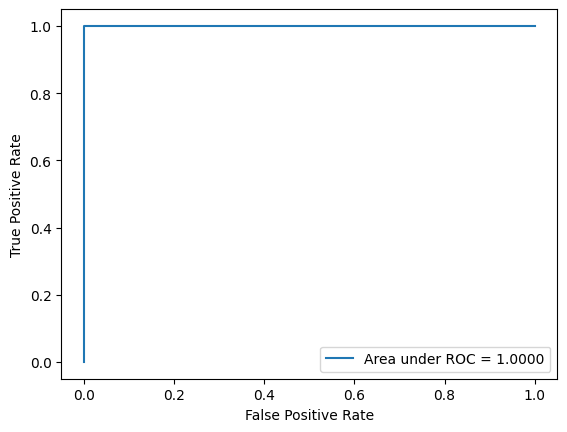

In [50]:
# plot the roc curve    
fpr, tpr, _ = roc_curve(y_label, y_score)
plt.plot(fpr, tpr, label = "Area under ROC = {:.4f}".format(roc_score))
plt.legend(loc = 'best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

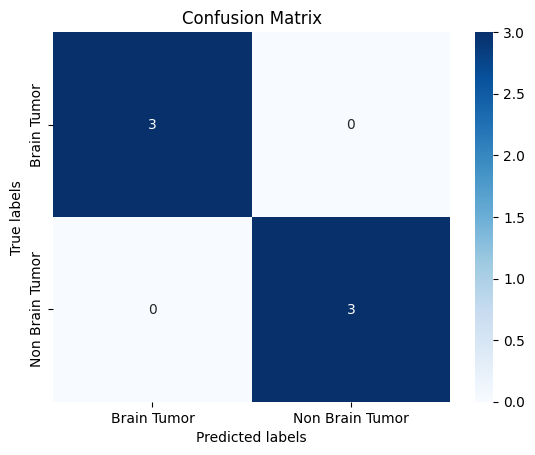

In [51]:
import seaborn as sns

conf_matrix = conf_matrix
ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, ax = ax, cmap = 'Blues'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Brain Tumor', 'Non Brain Tumor']); ax.yaxis.set_ticklabels(['Brain Tumor', 'Non Brain Tumor']);